
Dataset used:- "Indian vehicle license plate dataset"

Source:- https://www.kaggle.com/datasets/saisirishan/indian-vehicle-dataset?resource=download

Download via:- Download_kaggle_dataset.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./google_images\0073797c-a755-4972-b76b-8ef2b3...,140,339,210,260
1,./google_images\00b42b2c-f193-4863-b92c-0245cb...,184,292,572,648
2,./google_images\018b52e6-e9a1-42c2-8ce7-0617e8...,327,399,202,227
3,./google_images\03273806-bb1e-48da-8c8b-a0133a...,185,374,290,339
4,./google_images\0369b20e-b432-4409-90f9-242087...,335,453,313,347


In [3]:
import xml.etree.ElementTree as xet

In [8]:
filename = df['filepath'][0]
filename

'./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.xml'

In [9]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./google_images',filename_image)
    return filepath_image

In [10]:
getFilename(filename)

'./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg'

In [11]:
image_path = list(df['filepath'].apply(getFilename))
image_path 

['./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg',
 './google_images\\00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-Petrol-Review-Images-Black-Front-Angle.jpg',
 './google_images\\018b52e6-e9a1-42c2-8ce7-0617e8c8e021___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_sbtb02_auto1.JPG',
 './google_images\\03273806-bb1e-48da-8c8b-a0133a90197a___2014-Skoda-Yeti-Test-Drive.jpg.jpeg',
 './google_images\\0369b20e-b432-4409-90f9-2420877aa386___8151536c79159a1557421da5f27f9f0e.jpg.jpeg',
 './google_images\\07064c2c-2aa3-4419-91a4-92916de8e54c___mahindra-scorpio-old-car-500x500.jpg.jpeg',
 './google_images\\074d85b8-42ec-4d17-9b8e-9e51ae060243___hqdefault.jpg.jpeg',
 './google_images\\07aaab79-71ee-4ea3-a9e6-640191183947___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_1208484d1392541449-nissan-terrano-official-review-img_20140215_181708.jpg',
 './google_images\\07bd977e-d578-49a2-b345-7cee5a4db6bf___new_1031520d1356604430-skoda-r

#### Verify image and output

In [12]:
file_path = image_path[0]
file_path 

'./google_images\\0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG_20160315_071740.jpg.jpeg'

In [13]:
img = cv2.imread(file_path)

#cv2.namedWindow('example',cv2.WINDOW_NORMAL)
#cv2.imshow('example',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


cv2.namedWindow('imageWindow')
cv2.imshow('imageWindow',img)
wait = True
while wait:
  wait = cv2.waitKey()=='q113' # hit q to exit

In [14]:
# 1093	1396	645	727
cv2.rectangle(img,(140,210),(334,252),(0,255,0),3)
cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Data Preprocessing

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [12]:
labels = df.iloc[:,1:].values

In [13]:
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # pre-processing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [14]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [15]:
X.shape,y.shape

((440, 224, 224, 3), (440, 4))

In [16]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((352, 224, 224, 3), (88, 224, 224, 3), (352, 4), (88, 4))

### Deep Learning Model

In [17]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [18]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [19]:
# compile model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 25, 25, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 25, 25, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 25, 25, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 25, 25, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 25, 25, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 25, 25, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 25, 25, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 12, 12, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 12, 12, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 12, 12, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 12, 12, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 12, 12, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 12, 12, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 12, 12, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 12, 12, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 12, 12, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 12, 12, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 12, 12, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 12, 12, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 12, 12, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 12, 12, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 5, 5, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 5, 5, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 5, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 5, 5, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 38400)        0           ['conv_7b_ac[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 500)          19200500    ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 250)          125250      ['dense[0][0]']                  
                                                                                                  
 dense_2 (

### Model Training

In [20]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
tfb = TensorBoard('object_detection')
early_stopping = EarlyStopping()

In [22]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=200,
                    validation_data=(x_test,y_test), callbacks=[tfb])

Epoch 1/200
36/36 [==============================] - 388s 8s/step - loss: 0.1005 - val_loss: 0.0987
Epoch 2/200
36/36 [==============================] - 298s 8s/step - loss: 0.0834 - val_loss: 0.0621
Epoch 3/200
36/36 [==============================] - 304s 9s/step - loss: 0.0507 - val_loss: 0.0512
Epoch 4/200
36/36 [==============================] - 307s 9s/step - loss: 0.0456 - val_loss: 0.0443
Epoch 5/200
36/36 [==============================] - 272s 8s/step - loss: 0.0401 - val_loss: 0.0429
Epoch 6/200
36/36 [==============================] - 310s 9s/step - loss: 0.0381 - val_loss: 0.0430
Epoch 7/200
36/36 [==============================] - 305s 9s/step - loss: 0.0387 - val_loss: 0.0495
Epoch 8/200
36/36 [==============================] - 293s 8s/step - loss: 0.0379 - val_loss: 0.0443
Epoch 9/200
36/36 [==============================] - 283s 8s/step - loss: 0.0376 - val_loss: 0.0428
Epoch 10/200
36/36 [==============================] - 242s 7s/step - loss: 0.0372 - val_loss: 0.0439

36/36 [==============================] - 279s 8s/step - loss: 5.3391e-04 - val_loss: 0.0065
Epoch 158/200
36/36 [==============================] - 273s 8s/step - loss: 5.6957e-04 - val_loss: 0.0064
Epoch 159/200
36/36 [==============================] - 273s 8s/step - loss: 5.1722e-04 - val_loss: 0.0063
Epoch 160/200
36/36 [==============================] - 276s 8s/step - loss: 3.6902e-04 - val_loss: 0.0062
Epoch 161/200
36/36 [==============================] - 275s 8s/step - loss: 2.5740e-04 - val_loss: 0.0059
Epoch 162/200
36/36 [==============================] - 273s 8s/step - loss: 2.3311e-04 - val_loss: 0.0063
Epoch 163/200
36/36 [==============================] - 272s 8s/step - loss: 2.4745e-04 - val_loss: 0.0060
Epoch 164/200
36/36 [==============================] - 272s 8s/step - loss: 2.1044e-04 - val_loss: 0.0064
Epoch 165/200
36/36 [==============================] - 273s 8s/step - loss: 1.3048e-04 - val_loss: 0.0059
Epoch 166/200
36/36 [==============================] - 272s 

In [101]:
'''history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test),callbacks=[tfb],initial_epoch=101)'''

In [23]:
model.save('./models/_200_object_detection_indian-vehicle-dataset.h5')

In [ ]:
#It is preferable to create a small function for plotting metrics.:-

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

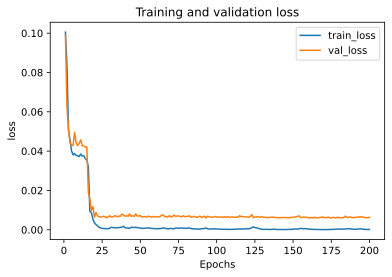

In [25]:
plot_metric(history, 'loss')

In [26]:
import keras

In [27]:
filename = r'./models/_200_object_detection_indian-vehicle-dataset.h5'

In [28]:
model = keras.models.load_model(filename)

In [29]:
#evaluate(): is for evaluating the already trained model using the validation (or test) data and the corresponding labels. 
#Returns the loss value and metrics values for the model.
model.evaluate(x_test,y_test)


3/3 [==============================] - 61s 14s/step - loss: 0.0062


0.006249417085200548